In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import datetime as dt

from tools_fast import make_track, make_ER, kalman_filter, ols_regression, lasso_regression, ridge_regression, ml_kalman_filter,\
    replication_stats
from hc_graph import hc_stock
sns.set()

<IPython.core.display.Javascript object>

Open console to check js libs were loaded in page


In [3]:
prices = pd.read_csv(r"financial_data/bnp_data.csv", index_col=0, parse_dates=True,
                     dayfirst=True)[['BNPIFEU','BNPIFE10',"SPGSGCP","BPFXCAD1"]]
#prices_risk_premia = pd.read_csv(r"financial_data/bnp_risk_premia_data.csv", index_col=0, parse_dates=True, 
#                                 dayfirst=True)[["BNPIMDEA"]]


#prices = pd.concat([prices_index, prices_risk_premia],axis=1).dropna()
returns = prices.pct_change().dropna()

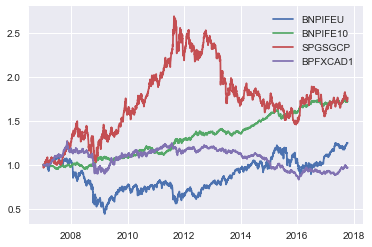

In [4]:
(prices/prices.iloc[0]).plot()

In [5]:
returns.corr(method="pearson")

,BNPIFEU,BNPIFE10,SPGSGCP,BPFXCAD1
BNPIFEU,1.000000,-0.472742,0.005528,0.477899
BNPIFE10,-0.472742,1.000000,0.096560,-0.247564
SPGSGCP,0.005528,0.096560,1.000000,0.282960
BPFXCAD1,0.477899,-0.247564,0.282960,1.000000


In [6]:
# n_reweight = 1000
# reweight_cal = returns.sample(n_reweight).sort_index().index
# df_reweight1 = pd.DataFrame(index=reweight_cal, data=np.random.normal(0.3, 0.1, size=(n_reweight, len(prices.columns))),
#                             columns=prices.columns)
# df_reweight1.to_pickle("df_reweight1.pkl")

df_reweight1 = pd.read_pickle("df_reweight1.pkl")

In [7]:
df_reweight1.head()

,BNPIFEU,BNPIFE10,SPGSGCP,BPFXCAD1
2007-01-12,0.413558,0.252977,0.259159,0.344376
2007-01-24,0.438023,0.342521,0.353628,0.443417
2007-01-26,0.443115,0.294232,0.263129,0.276773
2007-01-29,0.434850,0.340505,0.419259,0.352395
2007-01-30,0.209113,0.287956,0.232760,0.364696


In [8]:
# n_reweight = 500
# reweight_cal = returns.sample(n_reweight).sort_index().index
# df_reweight2 = pd.DataFrame(index=reweight_cal, data=np.random.normal(0.3, 0.2, size=(n_reweight, len(prices.columns))),
#                             columns=prices.columns)
# df_reweight2.to_pickle("df_reweight2.pkl")

df_reweight2 = pd.read_pickle("df_reweight2.pkl")

In [9]:
df_reweight2.head()

,BNPIFEU,BNPIFE10,SPGSGCP,BPFXCAD1
2007-01-29,0.438720,0.176435,0.116390,0.287326
2007-02-02,0.094326,0.542737,0.036040,0.573398
2007-02-07,0.203538,0.286680,0.247430,0.063441
2007-02-20,0.227404,0.114769,0.965287,0.508066
2007-02-21,-0.081782,0.174380,0.597206,0.250860


In [10]:
# n_reweight = 250
# reweight_cal = returns.sample(n_reweight).sort_index().index
# df_reweight3 = pd.DataFrame(index=reweight_cal, data=np.random.normal(0.3, 0.3, size=(n_reweight, len(prices.columns))),
#                             columns=prices.columns)
# df_reweight3.to_pickle("df_reweight3.pkl")

df_reweight3 = pd.read_pickle("df_reweight3.pkl")

In [11]:
df_reweight3.head()

,BNPIFEU,BNPIFE10,SPGSGCP,BPFXCAD1
2007-01-05,-0.469405,0.964442,0.165886,0.504426
2007-01-12,0.353327,-0.129618,0.271120,0.258277
2007-01-24,0.328386,0.544681,0.245177,0.490492
2007-01-31,-0.107485,0.436390,0.168076,0.239197
2007-02-13,-0.026790,0.016925,0.373630,0.700879


In [12]:
track1 = make_track(prices.loc[df_reweight1.index[0]:], df_reweight1, lag=0).rename(columns={'Track':'$Dynamic\ Portfolio\ 1$'})
track2 = make_track(prices.loc[df_reweight2.index[0]:], df_reweight2, lag=0).rename(columns={'Track':'$Dynamic\ Portfolio\ 2$'})
track3 = make_track(prices.loc[df_reweight3.index[0]:], df_reweight3, lag=0).rename(columns={'Track':'$Dynamic\ Portfolio\ 3$'})
track = track1.join(track2, how='inner').join(track3, how='inner')

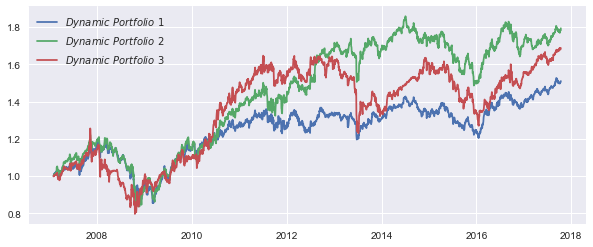

In [13]:
track.plot(figsize=(10,4))

In [14]:
## Replication Data
track_returns1 = track1.pct_change().dropna() + np.random.normal(0.0, 0.005, size=(len(track1.index)-1, 1))
track_returns2 = track2.pct_change().dropna() + np.random.normal(0.0, 0.005, size=(len(track2.index)-1, 1))
track_returns3 = track3.pct_change().dropna() + np.random.normal(0.0, 0.005, size=(len(track3.index)-1, 1))
universe_returns1 = returns.loc[track_returns1.index]
universe_returns2 = returns.loc[track_returns2.index]
universe_returns3 = returns.loc[track_returns3.index]

freq = 5

In [15]:
df_res = track.loc['2008':].copy()

In [16]:
%%time
nu = 0.2

df_weight_kalman1 = kalman_filter(track_returns1, universe_returns1, freq, sigma_weight=1., sigma_return=nu)
prices_for_track_kalman1 = prices.loc[df_weight_kalman1.index[0]:]
replication_kalman1 = make_track(prices_for_track_kalman1, df_weight_kalman1).loc[df_res.index[0]:]
df_res["$Kalman\ 1\ \\nu={}$".format(nu)] = replication_kalman1

df_weight_kalman2 = kalman_filter(track_returns2, universe_returns2, freq, sigma_weight=1., sigma_return=nu)
prices_for_track_kalman2 = prices.loc[df_weight_kalman2.index[0]:]
replication_kalman2 = make_track(prices_for_track_kalman2, df_weight_kalman2).loc[df_res.index[0]:]
df_res["$Kalman\ 2\ \\nu={}$".format(nu)] = replication_kalman2

df_weight_kalman3 = kalman_filter(track_returns3, universe_returns3, freq, sigma_weight=1., sigma_return=nu)
prices_for_track_kalman3 = prices.loc[df_weight_kalman3.index[0]:]
replication_kalman3 = make_track(prices_for_track_kalman3, df_weight_kalman3).loc[df_res.index[0]:]
df_res["$Kalman\ 3\ \\nu={}$".format(nu)] = replication_kalman3

Wall time: 6.85 s


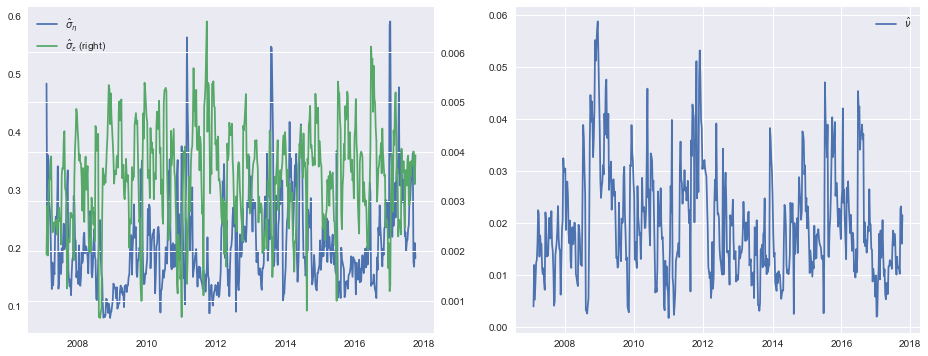

Wall time: 10min 26s


In [51]:
%%time
from tools import ml_kalman_filter2
df_weight_ml_kalman2, df_sigma2 = ml_kalman_filter2(track_returns2, universe_returns2, freq, mle_period=5, plot_sigma=True)

prices_for_track_kalman_ml2 = prices.loc[df_weight_ml_kalman2.index[0]:]
replication_kalman_ml2 = make_track(prices_for_track_kalman_ml2, df_weight_ml_kalman2).loc[df_res.index[0]:]
df_res["$ML\ Kalman\ 2$"] = replication_kalman_ml2

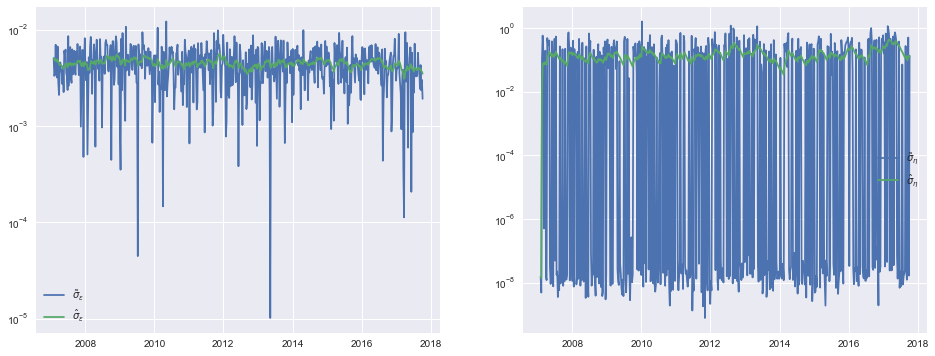

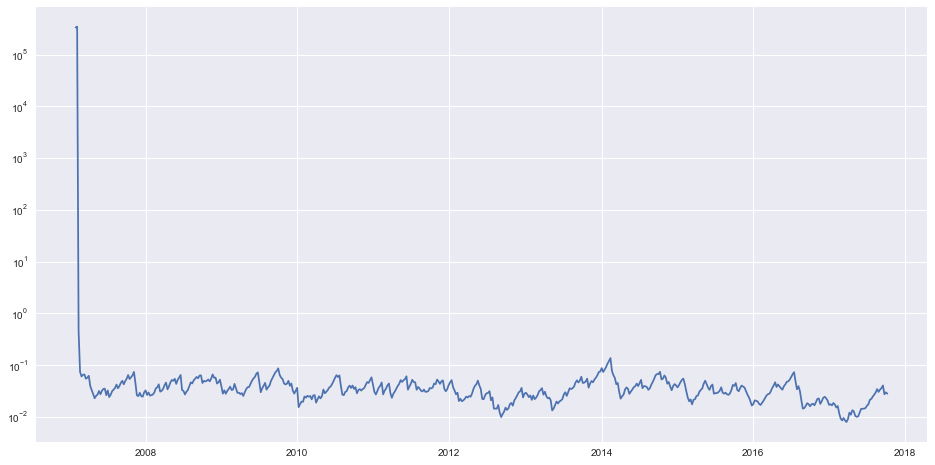

Wall time: 1min 7s


In [17]:
%%time
tau = 0.1

df_weight_ml_kalman1, _ = ml_kalman_filter(track_returns1, universe_returns1, freq, tau=tau)
prices_for_track_ml_kalman1 = prices.loc[df_weight_ml_kalman1.index[0]:]
replication_ml_kalman1 = make_track(prices_for_track_ml_kalman1, df_weight_ml_kalman1).loc[df_res.index[0]:]
df_res["$ML\ Kalman\ 1\ \\tau={}$".format(tau)] = replication_ml_kalman1

df_weight_ml_kalman2, _ = ml_kalman_filter(track_returns2, universe_returns2, freq, tau=tau, plot_sigma=True)
prices_for_track_ml_kalman2 = prices.loc[df_weight_ml_kalman2.index[0]:]
replication_ml_kalman2 = make_track(prices_for_track_ml_kalman2, df_weight_ml_kalman2).loc[df_res.index[0]:]
df_res["$ML\ Kalman\ 2\ \\tau={}$".format(tau)] = replication_ml_kalman2

df_weight_ml_kalman3, _ = ml_kalman_filter(track_returns3, universe_returns3, freq, tau=tau)
prices_for_track_ml_kalman3 = prices.loc[df_weight_ml_kalman3.index[0]:]
replication_ml_kalman3 = make_track(prices_for_track_ml_kalman3, df_weight_ml_kalman3).loc[df_res.index[0]:]
df_res["$ML\ Kalman\ 3\ \\tau={}$".format(tau)] = replication_ml_kalman3

In [18]:
df_res = df_res / df_res.iloc[0]
df_res.head()

,$Dynamic\ Portfolio\ 1$,$Dynamic\ Portfolio\ 2$,$Dynamic\ Portfolio\ 3$,$Kalman\ 1\ \nu=0.2$,$Kalman\ 2\ \nu=0.2$,$Kalman\ 3\ \nu=0.2$,$ML\ Kalman\ 1\ \tau=0.1$,$ML\ Kalman\ 2\ \tau=0.1$,$ML\ Kalman\ 3\ \tau=0.1$
2008-01-01,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.000000
2008-01-02,1.006628,1.004662,1.011516,1.001229,1.002667,1.008007,1.009074,1.0,1.002762
2008-01-03,1.012227,1.008286,1.016139,1.004497,1.007020,1.015708,1.014661,1.0,1.004115
2008-01-04,1.002228,0.999712,1.012044,0.997167,1.000715,1.004487,1.008149,1.0,1.000046
2008-01-07,1.000785,0.997832,1.010494,0.996038,0.998461,1.000926,1.006574,1.0,0.999618


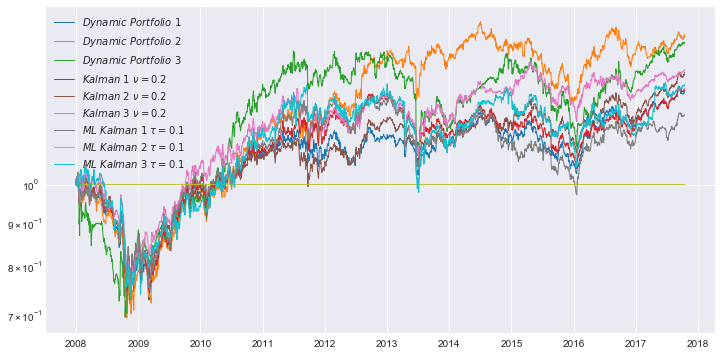

In [19]:
df_res.plot(figsize=(12,6),linewidth=1, logy=True, cmap='tab10')

In [20]:
g = hc_stock(df_res)
g.plot()

In [21]:
df_stat1 = replication_stats(df_res[['$Dynamic\ Portfolio\ 1$', "$Kalman\ 1\ \\nu={}$".format(nu),
                                   "$ML\ Kalman\ 1\ \\tau={}$".format(tau)]], fund_name='$Dynamic\ Portfolio\ 1$')
df_stat1

,Tracking error,R-squared,Sharpe ratio,Annual Return,Correlation,Kendall tau
$Dynamic\ Portfolio\ 1$,0.000000,1.000000,0.282052,0.025537,1.000000,1.000000
$Kalman\ 1\ \nu=0.2$,0.002380,0.885076,0.294067,0.026149,0.941088,0.814857
$ML\ Kalman\ 1\ \tau=0.1$,0.003309,0.777817,0.220679,0.019023,0.893892,0.737551


In [53]:
df_stat2 = replication_stats(df_res[['$Dynamic\ Portfolio\ 2$', "$Kalman\ 2\ \\nu={}$".format(nu),
                                   "$ML\ Kalman\ 2\ \\tau={}$".format(tau), "$ML\ Kalman\ 2$"]], fund_name='$Dynamic\ Portfolio\ 2$')
df_stat2

,Tracking error,R-squared,Sharpe ratio,Annual Return,Correlation,Kendall tau
$Dynamic\ Portfolio\ 2$,0.000000,1.000000,0.395365,0.041300,1.000000,1.000000
$Kalman\ 2\ \nu=0.2$,0.004235,0.690744,0.339928,0.030665,0.832038,0.677553
$ML\ Kalman\ 2\ \tau=0.1$,0.005232,0.527866,-0.004982,-0.008146,0.767970,0.604766
$ML\ Kalman\ 2$,0.005989,0.381337,-0.005432,-0.009248,0.717396,0.550107


In [23]:
df_stat3 = replication_stats(df_res[['$Dynamic\ Portfolio\ 3$', "$Kalman\ 3\ \\nu={}$".format(nu),
                                   "$ML\ Kalman\ 3\ \\tau={}$".format(tau)]], fund_name='$Dynamic\ Portfolio\ 3$')
df_stat3

,Tracking error,R-squared,Sharpe ratio,Annual Return,Correlation,Kendall tau
$Dynamic\ Portfolio\ 3$,0.000000,1.000000,0.344507,0.039149,1.000000,1.000000
$Kalman\ 3\ \nu=0.2$,0.005386,0.627030,0.319906,0.031483,0.793994,0.590108
$ML\ Kalman\ 3\ \tau=0.1$,0.005543,0.605033,0.262738,0.027332,0.802780,0.598596
